In [1]:
import os
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import pandas as pd
import numpy as np
from numpy import fft
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import cv2

from skimage.feature import hog, canny
from scipy.cluster.vq import kmeans, vq
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

### Load in Kaggle Data

In [2]:
# Loads a dataset from a subdirectory.
def load_dataset(datapath):
    df = pd.DataFrame( )
    
    for folder in os.listdir(datapath):
        files = glob(pathname= str(datapath + folder + '/*.jpg'))
        df = pd.concat( [ df, pd.DataFrame( { 'filename': files , 
                                              'category': folder } ) ] )
    
    df = df.sort_values(by="category", ignore_index=True)    
       
    return df

In [3]:
train_path = 'seg_train/seg_train/'

training_set = load_dataset(train_path)

In [4]:
#Remove images that are not (150,150)
resolution_col = []
for idx, row in training_set.iterrows():
    img = plt.imread(row['filename'])
    if img.shape == (150, 150, 3):
        resolution_col.append('good')
    else:
        resolution_col.append('drop')
        
new_training_set = training_set.copy()
new_training_set['resolution'] = resolution_col
new_training_set.drop(new_training_set[new_training_set.resolution == "drop"].index, inplace=True)

print("old", training_set.shape)
print("new", new_training_set.shape)

old (14034, 2)
new (13986, 3)


In [5]:
train, val = train_test_split(new_training_set, test_size=0.2, random_state = 314)

In [6]:
train.shape

(11188, 3)

In [7]:
val.shape

(2798, 3)

### Feature Functions

In [8]:
def HSV_feature(data):
    HSV_feature = []
    for idx, row in data.iterrows():
        img = Image.open(row["filename"])
        img_hsv = img.convert("HSV")
        HSV_feature.append(np.array(img_hsv.histogram()))
    HSV_feature_array = np.asarray(HSV_feature, dtype="object")
        
    return HSV_feature_array

In [9]:
HSV_example = HSV_feature(train)

In [15]:
def HOG_feature(data):
    HOG_feature = []
    for idx, row in data.iterrows():
        img = Image.open(row["filename"])
        HOG_img = hog(img, orientations=8, pixels_per_cell=(15, 15), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        HOG_feature.append(HOG_img[0])
    HOG_feature_array = pd.DataFrame(HOG_feature).fillna(0)
        
    return HOG_feature_array

In [16]:
HOG_example = HOG_feature(train)

In [19]:
def FOURIER_feature(data):
    FOURIER_feature = []
    for idx, row in data.iterrows():
        img = plt.imread(row['filename'])
        ydim = img.shape[0]
        xdim = img.shape[1]
        img_gray = img.mean(axis=2) #make the image grayscale by averaging all 3 channels
        win = np.outer(np.hanning(ydim), np.hanning(xdim))
        win = win/np.mean(win)
        fourier = fft.fftshift(fft.fft2(img_gray*win))
        Fmag = np.abs(fourier) 
        FOURIER_feature.append(np.log(Fmag).flatten())
        
    FEATURE_feature_array = pd.DataFrame(FOURIER_feature).fillna(0)
    return FEATURE_feature_array

In [20]:
FOURIER_example = FOURIER_feature(train)

In [23]:
def VGG16_feature(data):
    from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
    VGG16_feature = []
    vgg_model = VGG16(weights='imagenet')
    for idx, row in data.iterrows():
        img = image.load_img(row['filename'], color_mode='rgb', target_size=(224, 224))
        img = np.expand_dims(img, axis=0)
        input = preprocess_input(img)
        VGG16 = vgg_model.predict(input)
        VGG16_feature.append(VGG16)
    VGG16_feature_array = np.asarray(VGG16_feature, dtype="object").reshape(data.shape[0],1000)
        
    return VGG16_feature_array

In [24]:
VGG16_example = VGG16_feature(train)



1/1 [==============================] - 0s 401ms/step


In [27]:
def CANNY_feature(data):
    CANNY_feature = []
    for idx, row in data.iterrows():
        img = Image.open(row["filename"])
        gray_img = np.array(img.convert("L"))
        CANNY_img = canny(gray_img, sigma=2)
        CANNY_feature.append(CANNY_img.flatten())
    CANNY_feature_array = pd.DataFrame(CANNY_feature).fillna(0)
        
    return CANNY_feature_array

In [28]:
CANNY_example = CANNY_feature(train)

In [31]:
def add_bag_of_visual_word_feature(train_df):
    extractor = cv2.xfeatures2d.SIFT_create()
    k = 200 # number of visual words

    def add_sift(row):
        img = Image.open(row["filename"])
        img = np.array(img.convert("L"))
        img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
        row["keypoint"] = img_keypoints
        row["descriptor"] = img_descriptors
        return row

    def add_visual_words(row):
        img_descriptors = row["descriptor"]
        img_visual_words = []
        if img_descriptors is not None:
          img_visual_words, distance = vq(img_descriptors, codebook)
          row["visual_word"] = img_visual_words

        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        row["frequency_vector"] = img_frequency_vector
        return row

    # creating codebook for visual words
    train_df = train_df.apply(add_sift, axis=1)
    # test_df = test_df.apply(add_sift, axis=1)

    sample_index = train_df[train_df["descriptor"].notna()].sample(frac=0.2).index
    all_descriptors = np.vstack(train_df.loc[sample_index]["descriptor"].to_numpy())
    codebook, variance = kmeans(all_descriptors, k, 1)

    # compute tfidf
    train_df = train_df.apply(add_visual_words, axis=1)
    # test_df = test_df.apply(add_visual_words, axis=1)

    train_frequency_vectors = np.vstack(train_df["frequency_vector"])
    # test_frequency_vectors = np.vstack(test_df["frequency_vector"])
    idf = np.log(len(train_df) / np.sum(train_frequency_vectors > 0, axis=0))
    train_tfidf =  train_frequency_vectors * idf
    # test_tfidf = test_frequency_vectors * idf
    train_df["bag_of_visual_words"] = list(train_tfidf)
    # test_df["bag_of_visual_words"] = list(test_tfidf)
    return train_df

In [32]:
train_small_sub_bag = add_bag_of_visual_word_feature(train)

In [33]:
listbag = list(train_small_sub_bag['bag_of_visual_words'])

In [34]:
BAG_feature_array = pd.DataFrame(listbag).fillna(0)

### tSNE

In [10]:
def tSNE_calc(data):
    tsne = TSNE(n_components = 2, random_state = 0)
    x = tsne.fit_transform(data)
    return x

In [11]:
def tSNE_visual(tsne_calc, data, feature):
    for_plot = np.vstack((tsne_calc[:,0], tsne_calc[:,1], data["category"])).T
    for_plot_df = pd.DataFrame(for_plot, columns=["x", "y", "category"])
    
    #plot
    sns.scatterplot(x="x", y="y", data=for_plot_df, hue = "category", palette="icefire")
    plt.xlabel("Dimension 2")
    plt.ylabel("Dimension 1")
    
    if feature == "HSV":
        plt.title("Visualization of HSV tSNE in 2D")
    elif feature == "HOG":
        plt.title("Visualization of HOG tSNE in 2D")
    elif feature == "fourier":
        plt.title("Visualization of Fourier tSNE in 2D")
    elif feature == "VGG16":
        plt.title("Visualization of VGG16 tSNE in 2D")
    elif feature == "canny":
        plt.title("Visualization of Canny tSNE in 2D")
    elif feature == "bag of words":
        plt.title("Visualization of Bag of Visual Words tSNE in 2D")
    else:
        pass
                  
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    pass

In [12]:
tSNE_calc_HSV = tSNE_calc(HSV_example)

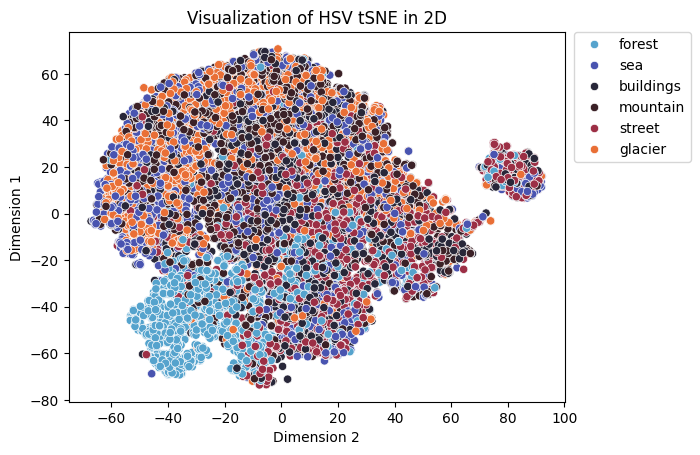

In [14]:
tSNE_visual(tSNE_calc_HSV, train, "HSV")

In [17]:
tSNE_calc_HOG = tSNE_calc(HOG_example)

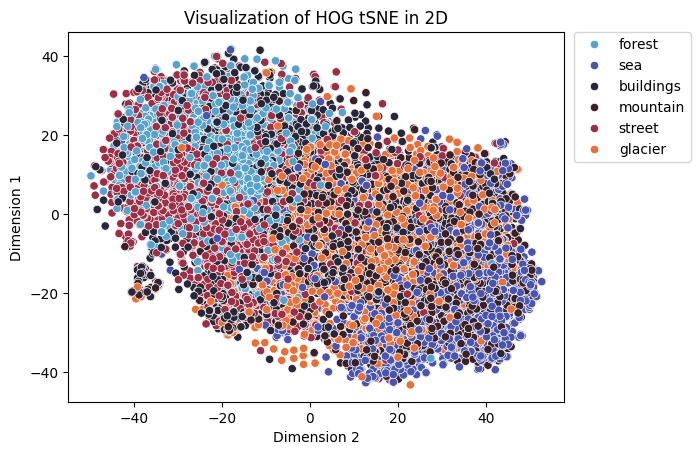

In [18]:
tSNE_visual(tSNE_calc_HOG, train, "HOG")

In [21]:
tSNE_calc_FOURIER = tSNE_calc(FOURIER_example)

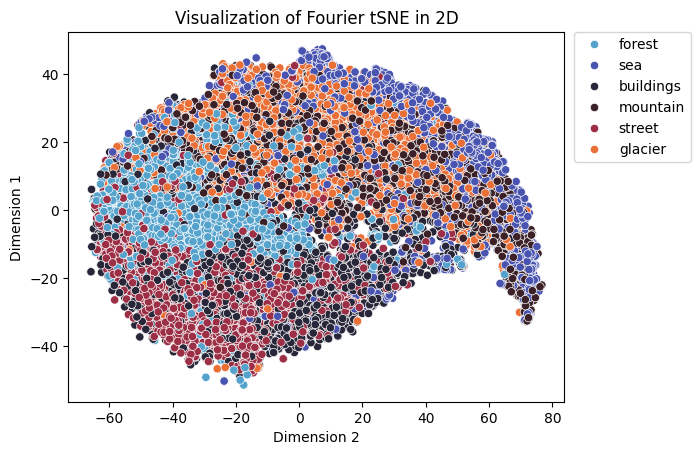

In [22]:
tSNE_visual(tSNE_calc_FOURIER, train, "fourier")

In [25]:
tSNE_calc_VGG16 = tSNE_calc(VGG16_example)

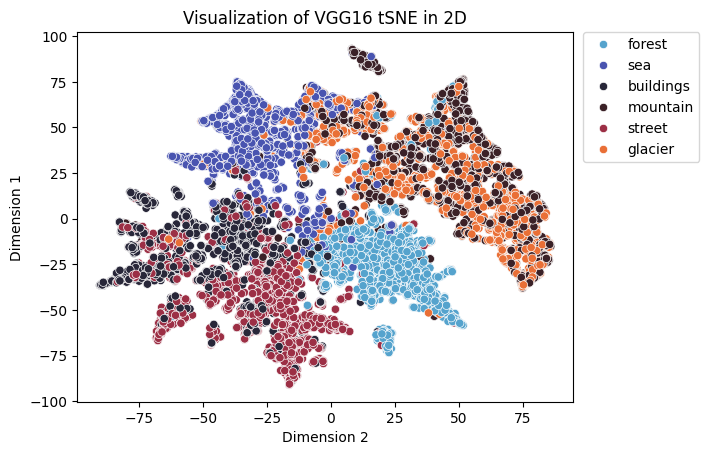

In [26]:
tSNE_visual(tSNE_calc_VGG16, train, "VGG16")

In [29]:
tSNE_calc_CANNY = tSNE_calc(CANNY_example)

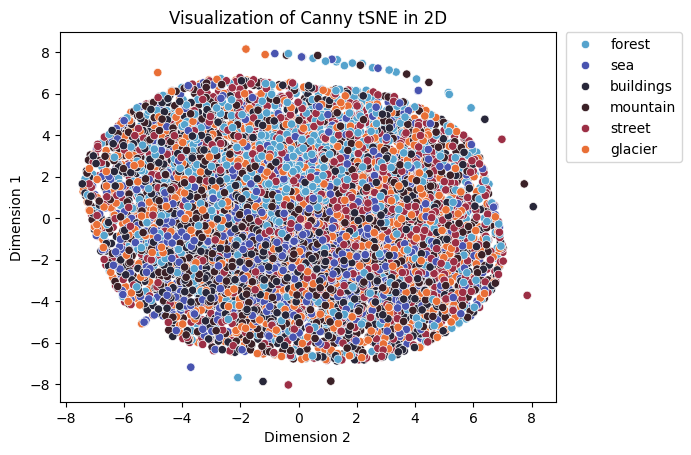

In [30]:
tSNE_visual(tSNE_calc_CANNY, train, "canny")

In [35]:
tSNE_calc_BAG = tSNE_calc(BAG_feature_array)

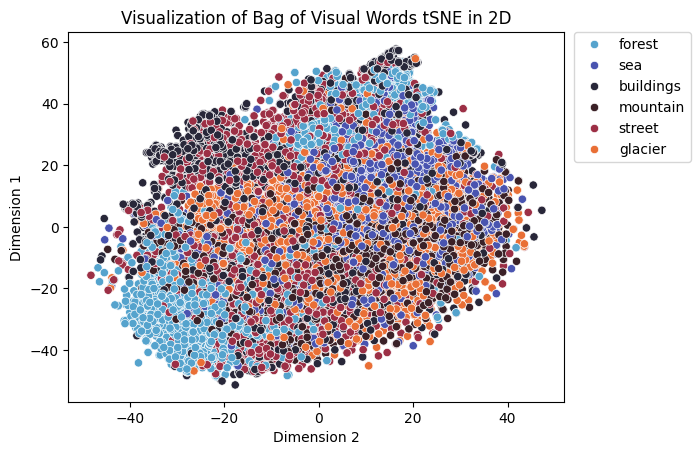

In [36]:
tSNE_visual(tSNE_calc_BAG, train, "bag of words")